In [1]:
import numpy as np
import pandas as pd
import scipy.signal as sp
import matplotlib.pyplot as plt
from pathlib import Path
from importImages import read_tif_from_folder
from images2crops import blobs_to_crops
from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow import keras, config
%matplotlib notebook

np.random.seed(3)

C:\Users\gongo\OneDrive - mail.tau.ac.il\Studies\Semester A\Research Project\ML_COCOS\images2crops.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  def blobs_to_crops(imgs, imgs_rgb, blobs_df, crop_dims=np.array([[-18, 6], [-5, 5], 3]), include_large_context=False):


In [2]:
def template_matching(img, temp, smart_norm=True, method='LOG'):
    if smart_norm:
        img = img / np.linalg.norm(img)
        temp = temp / np.linalg.norm(temp)
    else:
        img = 255 * img / np.max(img)
        temp = 255 * temp / np.max(temp)
    
    corr = np.array(sp.correlate2d(img, temp, mode="same"))

    if method == 'LOG':
        blobs_loc = np.array(feature.blob_log(corr, min_sigma=1, max_sigma=7, threshold=0.002)) # output is (y, x, sigma) was 0.002 for triplet (testing 0.005 for mid peak)

    elif method == 'DOG':
        blobs_loc = np.array(feature.blob_dog(corr, threshold=0.002)) # output is (y, x, sigma)
        
    return corr, blobs_loc

In [3]:
def template_matching_normed(img, temp):
    img = img / np.linalg.norm(img)
    temp = temp / np.linalg.norm(temp)
    
    corr = np.array(sp.correlate2d(img, temp, mode="same"))
    temp_ones = np.full_like(temp, 1)
    img_sqr = np.power(img, 2)
    corr_norm = np.array(sp.correlate2d(img_sqr, temp_ones, mode="same"))
    corr /= np.power(corr_norm, 0.5)

    blobs_loc = np.array(feature.blob_log(corr, min_sigma=1, max_sigma=7, threshold=0.25)) # output is (y, x, sigma)
    
    return corr, blobs_loc

In [4]:
def preprocessing (x, contrast_factor = 5):
    
    # BG_subtracting
    x = np.maximum(x - np.percentile(x, 70), 0)
    
    # strong dirty light subtracting
    x = np.minimum(x, np.median(x) + contrast_factor * x.std())
    
    return x

# Templates w\ themselves

<IPython.core.display.Javascript object>


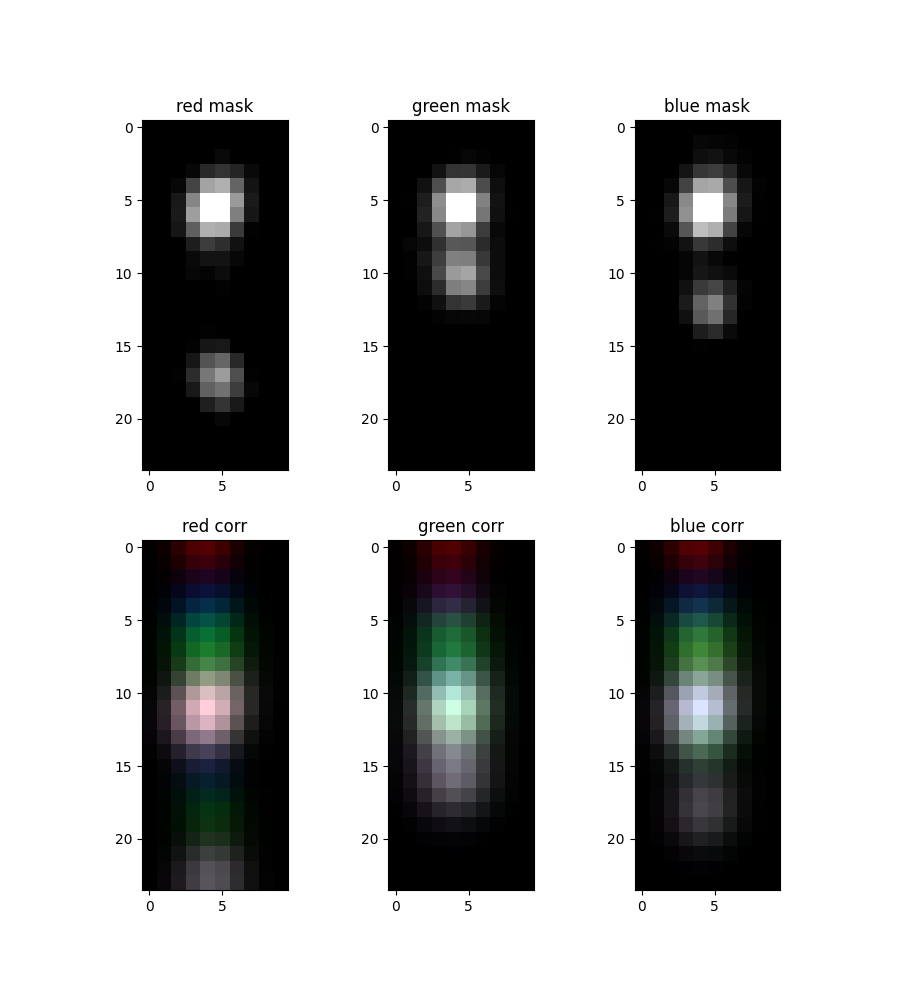

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [5]:
path = 'C:/Users/gongo/OneDrive - mail.tau.ac.il/Studies/Semester A/Research Project/ML_COCOS/masks + images/'
figure, axis = plt.subplots(2,3, figsize=(9,10))
temp_names = ['red_mir_mask.tif', 'green_mir_mask.tif', 'blue_mir_mask.tif']

for i, mask_name_1 in enumerate(temp_names):
    mat = np.zeros((3, 24, 10))
    mask1 = read_tif_from_folder(path + mask_name_1)
    mask1 = preprocessing(mask1)
    for j, mask_name_2 in enumerate(temp_names):
        mask2 = read_tif_from_folder(path + mask_name_2)
        mask2 = preprocessing(mask2)
        corr, blobs_loc = template_matching(mask1, mask2)
        mat[j] = corr
    axis[0,i].imshow(mask1, cmap='gray')
    axis[0,i].set_title(mask_name_1.split("_")[0] + ' mask')
    rgb_img = np.dstack([mat[j] for j in range(3)])
    axis[1,i].imshow(rgb_img)
    axis[1,i].set_title(mask_name_1.split("_")[0] + ' corr')
    
figure.savefig('templetes with themselfs rgb.png')

# Templates w\ each other

<IPython.core.display.Javascript object>


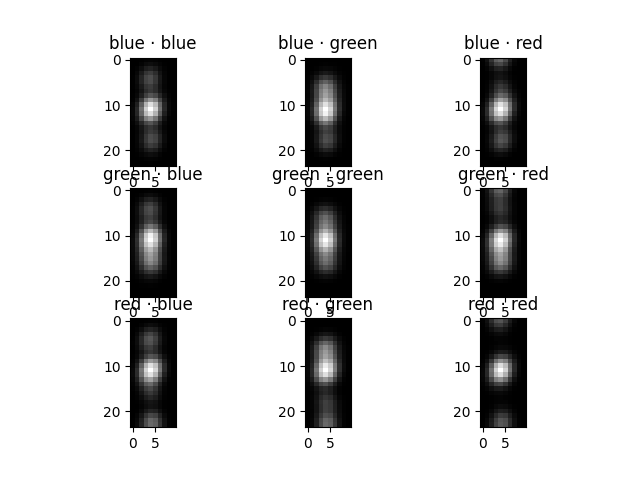

In [6]:
path = 'C:/Users/gongo/OneDrive - mail.tau.ac.il/Studies/Semester A/Research Project/ML_COCOS/masks + images/'
figure, axis = plt.subplots(3,3)
temp_names = ['blue_mir_mask.tif', 'green_mir_mask.tif', 'red_mir_mask.tif']

for i, temp_name1 in enumerate(temp_names):
    for j, temp_name2 in enumerate(temp_names):
        temp1 = read_tif_from_folder(path + temp_name1)
        temp2 = read_tif_from_folder(path + temp_name2)
        temp1 = preprocessing(temp1)
        temp2 = preprocessing(temp2)
        corr, blobs_loc = template_matching(temp1, temp2)
        axis[i,j].imshow(corr, cmap='gray')
        axis[i,j].set_title(temp_name1.split("_")[0] + ' · ' + temp_name2.split("_")[0])
        
figure.savefig('templetes with each other.png')

# With & Without Federbush's Normalization

<IPython.core.display.Javascript object>


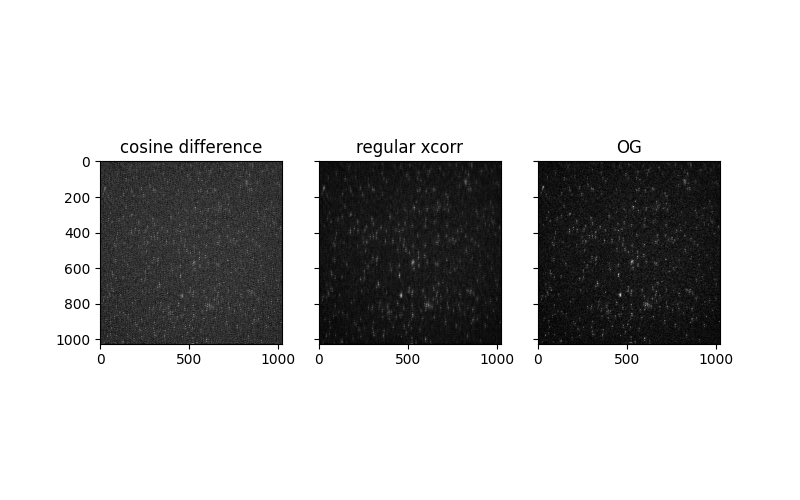

In [7]:
imgs = read_tif_from_folder(path + 'red_mir_3_images.tif')
temp = read_tif_from_folder(path + 'red_mir_mask.tif')

for i, img in enumerate(imgs):
    
    if i == 0:
        continue
        
    img = preprocessing(img)
    temp = preprocessing(temp)
    figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(8,5))
    axis[0].set_aspect('equal')
    axis[1].set_aspect('equal')
    corr1, blobs_loc1 = template_matching_normed(img, temp)
    corr2, blobs_loc2 = template_matching(img, temp)
    axis[0].imshow(corr1, cmap='gray')
    axis[0].set_title('cosine difference')
    axis[1].imshow(corr2, cmap='gray')
    axis[1].set_title('regular xcorr')
    axis[2].imshow(img, cmap='gray')
    axis[2].set_title('OG')
    
    plt.show()
    break

# Labaled Mixed Data - going to RGB

In [8]:
data_folder = Path('C:/Users/gongo/OneDrive - mail.tau.ac.il/Studies/Semester A/Research Project/ML_COCOS/wetransfer_mixed-mir-with-table_2023-07-01_2342/')
blobs_loc_by_TS_on_original_img_name = 'mixed miR for gon.csv'
imgs_names = 'validation_mix_NEW_1_1_1.tif'
imgs = read_tif_from_folder(data_folder / imgs_names)
blobs_loc_by_TS_on_original_img = pd.read_csv(data_folder / blobs_loc_by_TS_on_original_img_name)

masks_folder = Path('C:/Users/gongo/OneDrive - mail.tau.ac.il/Studies/Semester A/Research Project/ML_COCOS/masks + images/')
masks_names = ['red_mir_mask.tif', 'green_mir_mask.tif', 'blue_mir_mask.tif']

In [9]:
# Cross-correlation calculating between the samples and the templates
imgs_len = len(imgs)
rgb_images = np.zeros((imgs_len, 1024, 1024, 3))
for i, img in enumerate(imgs):
    img = preprocessing(img)  
    mat = np.zeros((3, 1024, 1024))
    for j, masks_name in enumerate(masks_names):
        mask = read_tif_from_folder(masks_folder / masks_name)
        mask = preprocessing(mask)
        corr, blobs_loc = template_matching(img, mask)
        mat[j] = corr
    rgb_images[i] = np.dstack([mat[j] for j in range(3)])
    print(i, 'out of', imgs_len)

    
np.save('RGB_corr_validation_mix_NEW_1_1_1.npy', rgb_images)

0 out of 362


KeyboardInterrupt: 

In [10]:
# Cropping the images
imgs_rgb = np.load('RGB_corr_validation_mix_NEW_1_1_1.npy')
blobs_loc_by_TS_on_original_img = pd.read_csv(data_folder / blobs_loc_by_TS_on_original_img_name)
crops, crops_rgb, success_mask = blobs_to_crops(imgs, imgs_rgb, blobs_loc_by_TS_on_original_img, crop_dims=np.array([[-11, 23], [-5, 5], 3], dtype=object))

np.save('crops.npy', crops)
np.save('crops_rgb.npy', crops_rgb)
np.save('success_mask.npy', success_mask)

In [11]:
# Load the data
crops = np.load('crops.npy')
crops_rgb = np.load('crops_rgb.npy')
mask = np.load('success_mask.npy')
class_labels = ['Red', 'Green', 'Blue', 'Noise']

# Check for GPU and if exists  run the training on it.
physical_devices = config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    config.experimental.set_memory_growth(physical_devices[0], True)
    
# Preprocess the data
cond = blobs_loc_by_TS_on_original_img['is_really_mir'] == 0
y = blobs_loc_by_TS_on_original_img['selected_mir_type'].copy()
y[cond] = 3 # Noise group
y = y[mask]
mask_manually_erase = y != -1 # Boolean indexing to remove -1 elements
y = y[mask_manually_erase] # Our GT
crops = crops[mask_manually_erase]
crops_rgb = crops_rgb[mask_manually_erase]

<IPython.core.display.Javascript object>


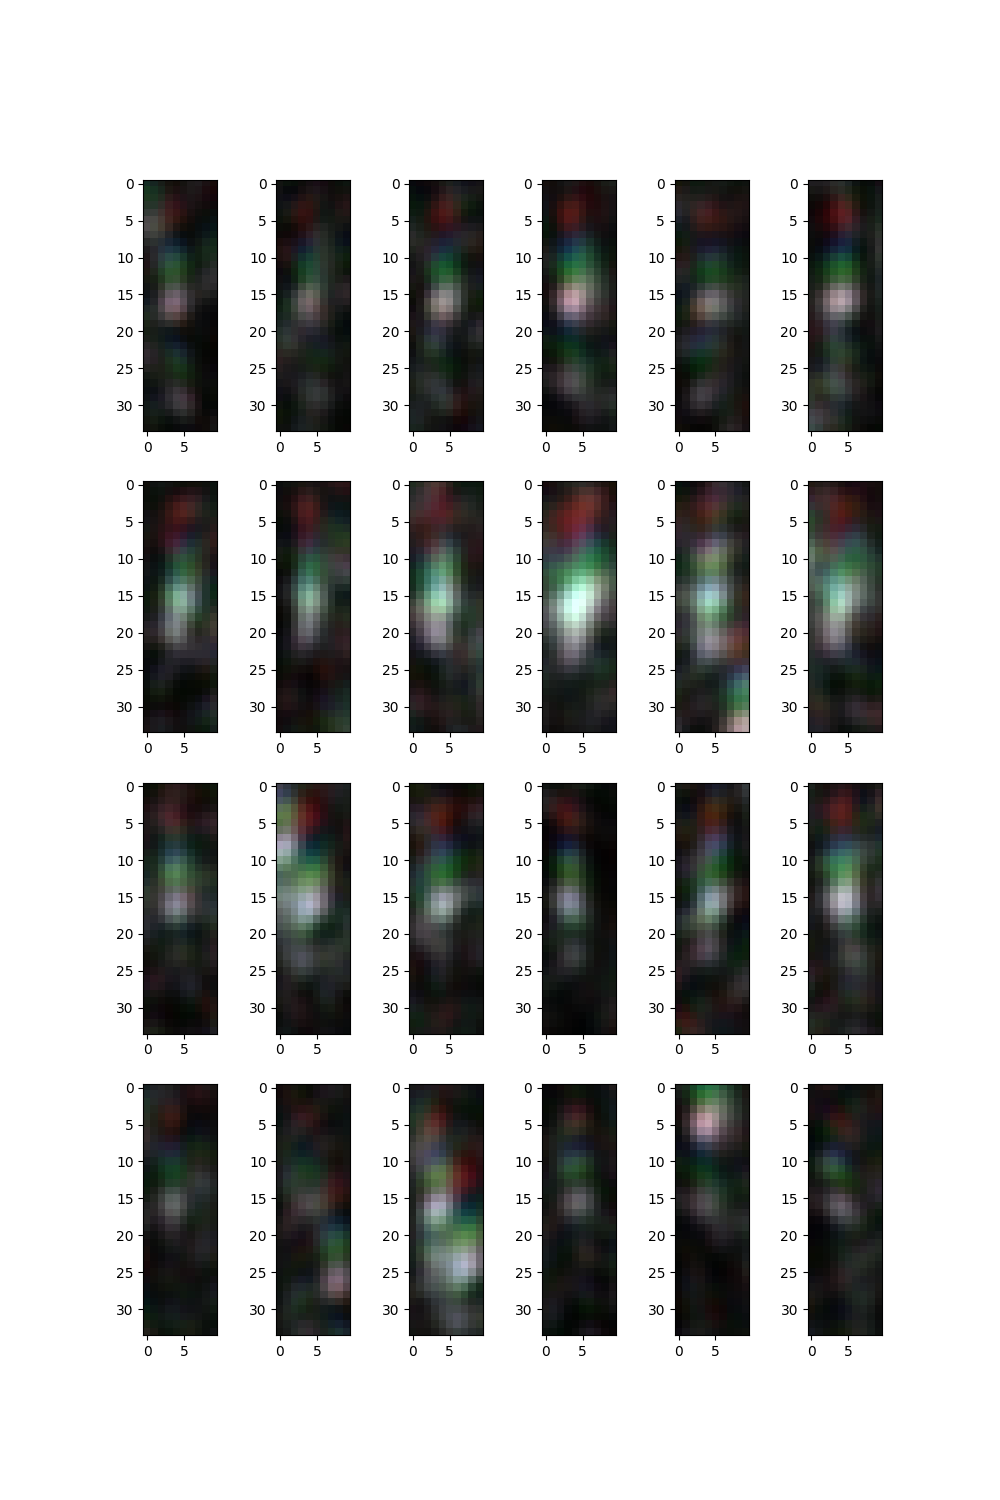

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [12]:
# Examples for different miR classes 
figure, axis = plt.subplots(4,6, figsize=(10,15))
for i in range(4):
    indexes = np.where(y == i)[0][:6]
    for pos, j in enumerate(indexes):
        axis[i,pos].set_aspect('equal')
        axis[i,pos].imshow(crops_rgb[j] * 50)

plt.show()

In [13]:
# Presenting data about the model
model = keras.Sequential(
    [
        keras.layers.Conv2D(12, kernel_size=(5, 5), activation="relu", input_shape=(34, 10, 3), padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(16, kernel_size=(5, 5), activation="relu", padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(20, activation="relu"),
        keras.layers.Dense(4, activation="softmax"),
    ]
)

# Print the summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 34, 10, 12)        912       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 5, 12)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 5, 16)         4816      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 2, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 20)                5

Epoch 1/10
19/19 - 3s - loss: 0.9019 - val_loss: 0.6186 - 3s/epoch - 157ms/step
Epoch 2/10
19/19 - 1s - loss: 0.5692 - val_loss: 0.4457 - 1s/epoch - 63ms/step
Epoch 3/10
19/19 - 1s - loss: 0.4103 - val_loss: 0.3950 - 1s/epoch - 66ms/step
Epoch 4/10
19/19 - 1s - loss: 0.3648 - val_loss: 0.3288 - 1s/epoch - 66ms/step
Epoch 5/10
19/19 - 1s - loss: 0.3303 - val_loss: 0.3266 - 1s/epoch - 63ms/step
Epoch 6/10
19/19 - 1s - loss: 0.3074 - val_loss: 0.3244 - 1s/epoch - 66ms/step
Epoch 7/10
19/19 - 1s - loss: 0.2813 - val_loss: 0.3296 - 1s/epoch - 66ms/step
Epoch 8/10
19/19 - 1s - loss: 0.2605 - val_loss: 0.3240 - 1s/epoch - 58ms/step
Epoch 9/10
19/19 - 1s - loss: 0.2451 - val_loss: 0.3149 - 1s/epoch - 53ms/step
Epoch 10/10
19/19 - 1s - loss: 0.2315 - val_loss: 0.3300 - 880ms/epoch - 46ms/step
26/26 [==============================] - 0s 9ms/step


<IPython.core.display.Javascript object>


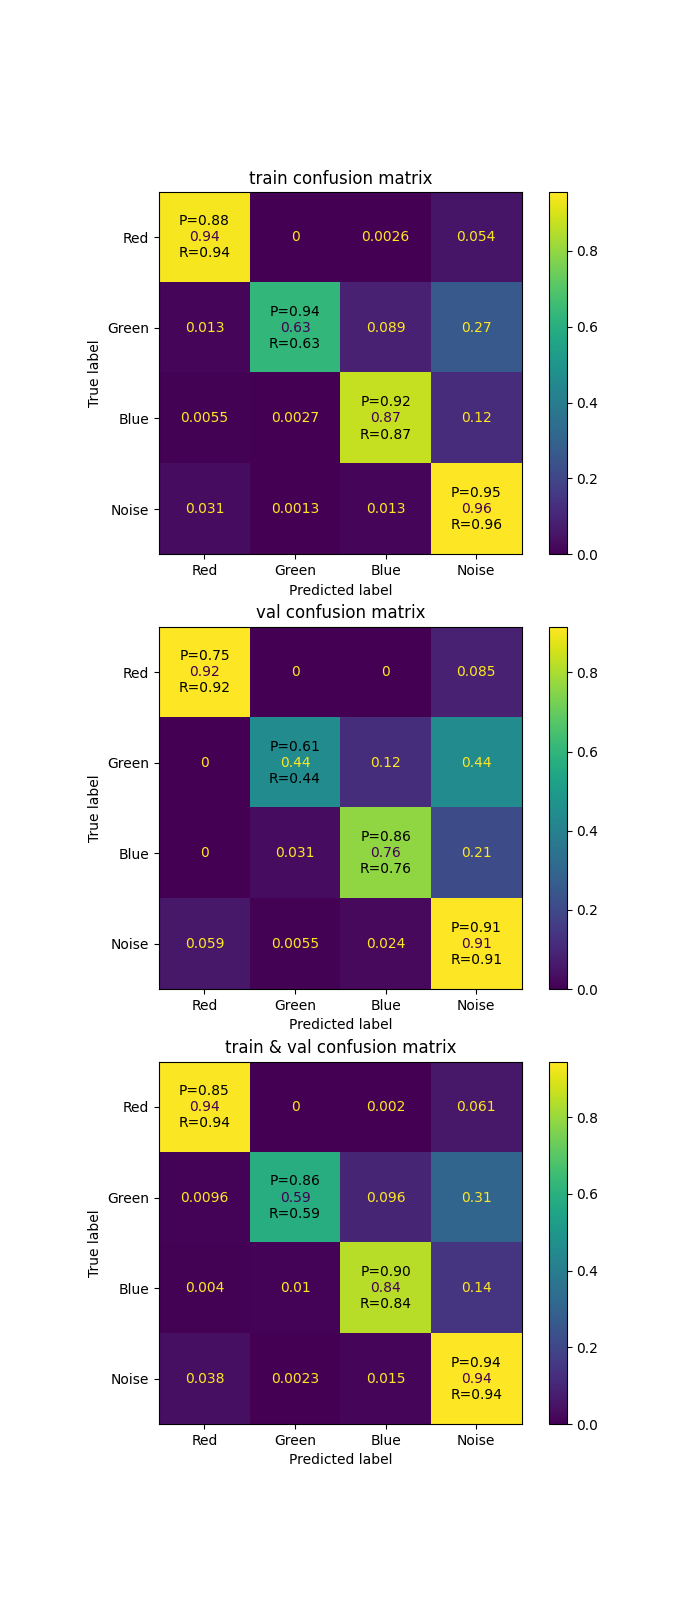

In [14]:
# Split the data into train, validation, and test sets
np.random.seed(3)
X_train, X_test, y_train, y_test = train_test_split(crops_rgb, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=42) # 0.8*0.25=0.2

# Reshape the data
X_train = X_train.reshape(len(X_train), -1)
X_val = X_val.reshape(len(X_val), -1)
X_test = X_test.reshape(len(X_test), -1)

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the data
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape the data back to the original shape
X_train = X_train.reshape(-1, 34, 10, 3)
X_val = X_val.reshape(-1, 34, 10, 3)
X_test = X_test.reshape(-1, 34, 10, 3)

# Convert labels to categorical
num_classes = len(np.unique(y))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define the LeNet model architecture
model = keras.Sequential(
    [
        keras.layers.Conv2D(12, kernel_size=(5, 5), activation="relu", input_shape=(34, 10, 3), padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(16, kernel_size=(5, 5), activation="relu", padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(20, activation="relu"),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=2e-3))

# Train the model
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val), verbose=2)





# Normalize Confusion Matricies after Yohai notes
# Evaluate the model
y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)  # Convert predictions to class labels
y_pred_val = model.predict(X_val)
y_pred_val = np.argmax(y_pred_val, axis=1)  # Convert predictions to class labels
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)

# Initilizing Confusion Matricies for each dataset
cm_train = metrics.confusion_matrix(y_true_train, y_pred_train).astype(float)
cm_val = metrics.confusion_matrix(y_true_val, y_pred_val).astype(float)
cm_train_val = metrics.confusion_matrix(np.concatenate((y_true_train,y_true_val)), np.concatenate((y_pred_train,y_pred_val))).astype(float)

cm_train_norm = np.zeros_like(cm_train)
cm_val_norm = np.zeros_like(cm_val)
cm_train_val_norm = np.zeros_like(cm_train_val)

for i in range(num_classes):
    sum_train = np.sum(cm_train[i])
    sum_val = np.sum(cm_val[i])
    sum_train_val = np.sum(cm_train_val[i])
    
    cm_train_norm[i] = cm_train[i] / sum_train
    cm_val_norm[i] = cm_val[i] / sum_val
    cm_train_val_norm[i] = cm_train_val[i] / sum_train_val
        
# Visualize the confusion matrix as a heatmap
fig, axis = plt.subplots(3, figsize=(7, 16))
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_train_norm, display_labels = class_labels).plot(ax=axis[0])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_val_norm, display_labels = class_labels).plot(ax=axis[1])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_train_val_norm, display_labels = class_labels).plot(ax=axis[2])
axis[0].set_title('train confusion matrix')
axis[1].set_title('val confusion matrix')
axis[2].set_title('train & val confusion matrix')

# Calculate precision and recall for each class
precision = lambda true_positives, false_positives: 1.0 if false_positives == 0 else true_positives / (true_positives + false_positives)
recall = lambda true_positives, false_negatives: 1.0 if false_negatives == 0 else true_positives / (true_positives + false_negatives)

precision_train = np.zeros(num_classes)
precision_val = np.zeros(num_classes)
precision_train_val = np.zeros(num_classes)
recall_train = np.zeros(num_classes)
recall_val = np.zeros(num_classes)
recall_train_val = np.zeros(num_classes)

for i in range(num_classes):
    true_positives = cm_train[i, i]
    false_positives = sum(cm_train[:, i]) - true_positives
    false_negatives = sum(cm_train[i, :]) - true_positives
    precision_train[i] = precision(true_positives, false_positives)
    recall_train[i] = recall(true_positives, false_negatives)

    true_positives = cm_val[i, i]
    false_positives = sum(cm_val[:, i]) - true_positives
    false_negatives = sum(cm_val[i, :]) - true_positives
    precision_val[i] = precision(true_positives, false_positives)
    recall_val[i] = recall(true_positives, false_negatives)

    true_positives = cm_train_val[i, i]
    false_positives = sum(cm_train_val[:, i]) - true_positives
    false_negatives = sum(cm_train_val[i, :]) - true_positives
    precision_train_val[i] = precision(true_positives, false_positives)
    recall_train_val[i] = recall(true_positives, false_negatives)

    # Annotate the plot with precision and recall values
    axis[0].text(i, i, f'P={precision_train[i]:.2f}\n\nR={recall_train[i]:.2f}', ha='center', va='center', color='k')
    axis[1].text(i, i, f'P={precision_val[i]:.2f}\n\nR={recall_val[i]:.2f}', ha='center', va='center', color='k')
    axis[2].text(i, i, f'P={precision_train_val[i]:.2f}\n\nR={recall_train_val[i]:.2f}', ha='center', va='center', color='k')

model.save("trained_model9.h5")
fig.savefig('cm_img9(12, 16, 20, (5, 5), (2, 2), 2e-3).png')
np.save('cm_data9(12, 16, 20, (5, 5), (2, 2), 2e-3).npy', [cm_train, cm_val, cm_train_val])
np.save('cm_sets9(12, 16, 20, (5, 5), (2, 2), 2e-3).npy', [X_train, X_val, X_test, y_train, y_val, y_test])


plt.show()

26/26 [==============================] - 0s 8ms/step


<IPython.core.display.Javascript object>


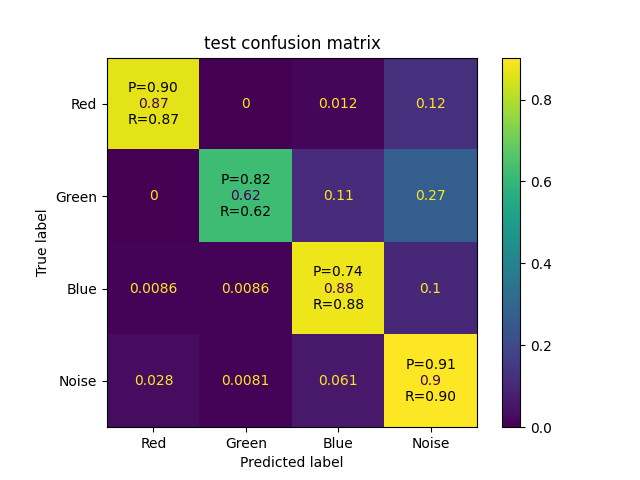

In [15]:
# Test set
model = keras.models.load_model("trained_model2.h5")
X_train, X_val, X_test, y_train, y_val, y_test = np.load('cm_sets2(12, 16, 20, (5, 5), (2, 2), 2e-3).npy', allow_pickle=True)


# Evaluate the model
num_classes = len(y_test[0])
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)  # Convert predictions to class labels
y_true_test = np.argmax(y_test, axis=1)

# Initilizing Confusion Matricies for each dataset
cm = metrics.confusion_matrix(y_true_test, y_pred_test).astype(float)
cm_norm = np.zeros_like(cm)

for i in range(num_classes):
    sum_test = np.sum(cm[i])
    cm_norm[i] = cm[i] / sum_test
        
# Visualize the confusion matrix as a heatmap
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_norm, display_labels = class_labels).plot()
plt.title('test confusion matrix')

# Calculate precision and recall for each class
precision = lambda true_positives, false_positives: 1.0 if false_positives == 0 else true_positives / (true_positives + false_positives)
recall = lambda true_positives, false_negatives: 1.0 if false_negatives == 0 else true_positives / (true_positives + false_negatives)

precision_test = np.zeros(num_classes)
recall_test = np.zeros(num_classes)

for i in range(num_classes):
    true_positives = cm[i, i]
    false_positives = sum(cm[:, i]) - true_positives
    false_negatives = sum(cm[i, :]) - true_positives
    precision_test[i] = precision(true_positives, false_positives)
    recall_test[i] = recall(true_positives, false_negatives)

    # Annotate the plot with precision and recall values
    plt.text(i, i, f'P={precision_test[i]:.2f}\n\nR={recall_test[i]:.2f}', ha='center', va='center', color='k')

plt.savefig('cm_test2(12, 16, 20, (5, 5), (2, 2), 2e-3).png')
np.save('cm_test_data2(12, 16, 20, (5, 5), (2, 2), 2e-3).npy', [cm])
    
plt.show()

26/26 [==============================] - 0s 9ms/step


<IPython.core.display.Javascript object>


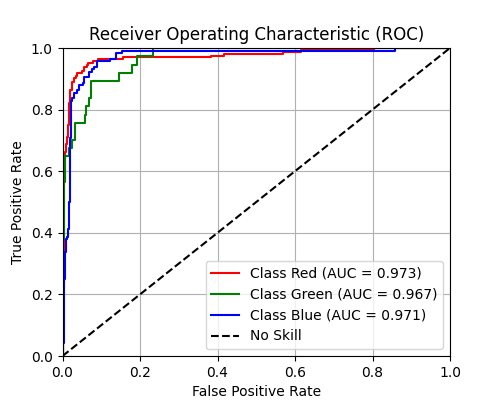

26/26 [==============================] - 0s 8ms/step
(808, 4)


<IPython.core.display.Javascript object>


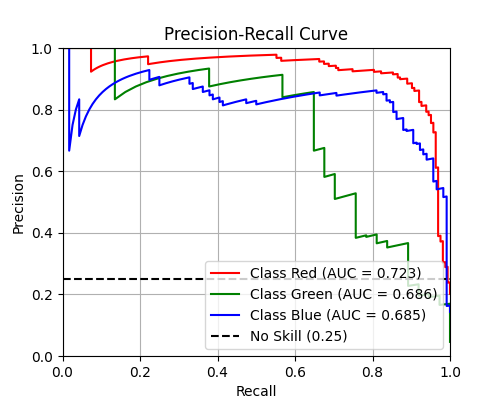

In [16]:
# Compute ROC curve and AUC for each class
model = keras.models.load_model("trained_model2.h5")
X_train, X_val, X_test, y_train, y_val, y_test = np.load('cm_sets2(12, 16, 20, (5, 5), (2, 2), 2e-3).npy', allow_pickle=True)

y_pred_prob = model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(y_test[0])
for i in range(num_classes-1):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
# Plot ROC curves for each class
plt.figure(figsize=(5, 4))
plt.plot(fpr[0], tpr[0], '-r', label='Class {} (AUC = {:.3f})'.format(class_labels[0], roc_auc[0]))
plt.plot(fpr[1], tpr[1], '-g', label='Class {} (AUC = {:.3f})'.format(class_labels[1], roc_auc[1]))
plt.plot(fpr[2], tpr[2], '-b', label='Class {} (AUC = {:.3f})'.format(class_labels[2], roc_auc[2]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)

plt.savefig('ROC2(12, 16, 20, (5, 5), (2, 2), 2e-3).png')
np.save('ROC_data2(12, 16, 20, (5, 5), (2, 2), 2e-3).npy', [fpr, tpr])

plt.show()


# Compute Precision-Recall curve and AUC for each class
y_scores = model.predict(X_test)
print(y_test.shape)

precision = dict()
recall = dict()
pr_auc = dict()

for i in range(num_classes-1):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i], y_scores[:, i])
    sorted_indices = np.argsort(precision[i])
    sorted_precision = precision[i][sorted_indices]
    sorted_recall = recall[i][sorted_indices]
    pr_auc[i] = metrics.auc(sorted_precision, sorted_recall)

# Plot the Precision-Recall curve for each class
plt.figure(figsize=(5, 4))
plt.plot(recall[0], precision[0], '-r', label='Class {} (AUC = {:.3f})'.format(class_labels[0], pr_auc[0]))
plt.plot(recall[1], precision[1], '-g', label='Class {} (AUC = {:.3f})'.format(class_labels[1], pr_auc[1]))
plt.plot(recall[2], precision[2], '-b', label='Class {} (AUC = {:.3f})'.format(class_labels[2], pr_auc[2]))

plt.plot([0, 1], [1/4, 1/4], 'k--', label='No Skill (0.25)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.grid(True)

plt.savefig('PRC2(12, 16, 20, (5, 5), (2, 2), 2e-3).png')
np.save('PRC_data2(12, 16, 20, (5, 5), (2, 2), 2e-3).npy', [recall, precision])

plt.show()

26/26 [==============================] - 0s 6ms/step


<IPython.core.display.Javascript object>


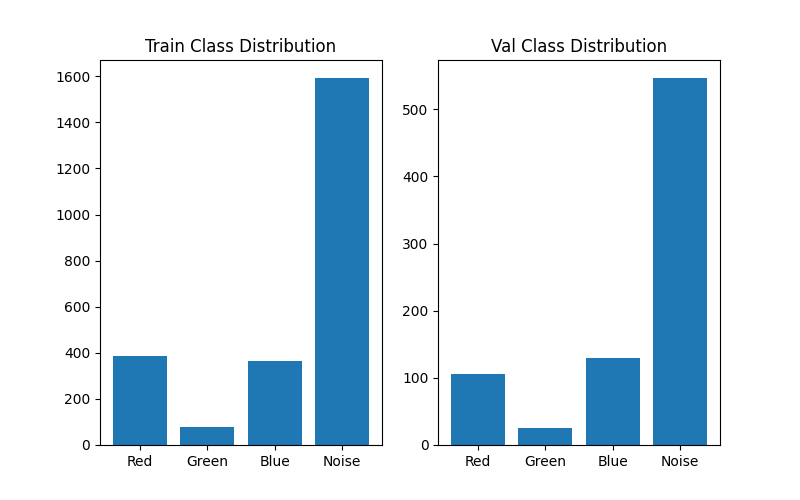

In [17]:
# Count the occurrences of each class
class_counts_train = np.sum(y_train, axis=0)
class_counts_val = np.sum(y_val, axis=0)

# Get the predicted labels for the validation set
y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)  # Convert predictions to class labels
y_pred_val = model.predict(X_val)
y_pred_val = np.argmax(y_pred_val, axis=1)  # Convert predictions to class labels

# Plot the bar graph
figure, axis = plt.subplots(1,2, figsize=(8,5))
axis[0].bar(class_labels, class_counts_train)
axis[0].set_label('Class')
axis[0].set_label('Count')
axis[0].set_title('Train Class Distribution')
axis[0].set_xticks(np.arange(len(class_labels)), class_labels)

axis[1].bar(class_labels, class_counts_val)
axis[1].set_label('Class')
axis[1].set_label('Count')
axis[1].set_title('Val Class Distribution')
axis[1].set_xticks(np.arange(len(class_labels)), class_labels)

plt.show()

figure.savefig('occurrences of each class')

In [18]:
def lenet5_same(filter_size1, filter_size2, filter_size3, kernel_size, pool_size, lr):

    # Split the data into train, validation, and test sets
    np.random.seed(3)
    X_train, X_test, y_train, y_test = train_test_split(crops_rgb, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=42) # 0.8*0.25=0.2

    # Reshape the data
    X_train = X_train.reshape(len(X_train), -1)
    X_val = X_val.reshape(len(X_val), -1)
    X_test = X_test.reshape(len(X_test), -1)

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Normalize the data
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Reshape the data back to the original shape
    X_train = X_train.reshape(-1, 34, 10, 3)
    X_val = X_val.reshape(-1, 34, 10, 3)
    X_test = X_test.reshape(-1, 34, 10, 3)

    # Convert labels to categorical
    num_classes = len(np.unique(y))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    # Define the LeNet model architecture
    model = keras.Sequential(
        [
            keras.layers.Conv2D(filter_size1, kernel_size=kernel_size, activation="relu", input_shape=(34, 10, 3), padding='same'),
            keras.layers.MaxPooling2D(pool_size=pool_size, padding='same'),
            keras.layers.Conv2D(filter_size2, kernel_size=kernel_size, activation="relu", padding='same'),
            keras.layers.MaxPooling2D(pool_size=pool_size, padding='same'),
            keras.layers.Flatten(),
            keras.layers.Dense(filter_size3, activation="relu"),
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

    
    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=lr))

    # Train the model
    model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val), verbose=2)

    # Evaluate the model
    y_pred_train = model.predict(X_train)
    y_pred_train = np.argmax(y_pred_train, axis=1)  # Convert predictions to class labels
    y_pred_val = model.predict(X_val)
    y_pred_val = np.argmax(y_pred_val, axis=1)  # Convert predictions to class labels
    y_true_train = np.argmax(y_train, axis=1)
    y_true_val = np.argmax(y_val, axis=1)
    
    # Calculate precision and recall for each class
    cm_train = metrics.confusion_matrix(y_true_train, y_pred_train)
    cm_val = metrics.confusion_matrix(y_true_val, y_pred_val)
    
    precision_train = np.zeros(num_classes)
    recall_train = np.zeros(num_classes)
    precision_val = np.zeros(num_classes)
    recall_val = np.zeros(num_classes)
    
    for i in range(num_classes):
        true_positives = cm_train[i, i]
        false_positives = sum(cm_train[:, i]) - true_positives
        false_negatives = sum(cm_train[i, :]) - true_positives
        precision_train[i] = 1.0 if false_positives == 0 else true_positives / (true_positives + false_positives)
        recall_train[i] = 1.0 if false_negatives == 0 else true_positives / (true_positives + false_negatives)

        true_positives = cm_val[i, i]
        false_positives = sum(cm_val[:, i]) - true_positives
        false_negatives = sum(cm_val[i, :]) - true_positives
        precision_val[i] =  1.0 if false_positives == 0 else true_positives / (true_positives + false_positives)
        recall_val[i] = 1.0 if false_negatives == 0 else true_positives / (true_positives + false_negatives)

    return precision_train, recall_train, precision_val, recall_val

Epoch 1/10
19/19 - 2s - loss: 1.3853 - val_loss: 1.2724 - 2s/epoch - 114ms/step
Epoch 2/10
19/19 - 1s - loss: 1.1996 - val_loss: 1.1278 - 837ms/epoch - 44ms/step
Epoch 3/10
19/19 - 1s - loss: 1.0838 - val_loss: 1.0245 - 863ms/epoch - 45ms/step
Epoch 4/10
19/19 - 1s - loss: 1.0021 - val_loss: 0.9513 - 831ms/epoch - 44ms/step
Epoch 5/10
19/19 - 1s - loss: 0.9469 - val_loss: 0.9017 - 886ms/epoch - 47ms/step
Epoch 6/10
19/19 - 1s - loss: 0.9099 - val_loss: 0.8673 - 881ms/epoch - 46ms/step
Epoch 7/10
19/19 - 1s - loss: 0.8833 - val_loss: 0.8419 - 935ms/epoch - 49ms/step
Epoch 8/10
19/19 - 1s - loss: 0.8621 - val_loss: 0.8216 - 862ms/epoch - 45ms/step
Epoch 9/10
19/19 - 1s - loss: 0.8437 - val_loss: 0.8040 - 877ms/epoch - 46ms/step
Epoch 10/10
19/19 - 1s - loss: 0.8268 - val_loss: 0.7882 - 876ms/epoch - 46ms/step
26/26 [==============================] - 0s 8ms/step
Epoch 1/10
19/19 - 2s - loss: 1.1932 - val_loss: 1.0473 - 2s/epoch - 103ms/step
Epoch 2/10
19/19 - 1s - loss: 0.9912 - val_loss:

26/26 [==============================] - 0s 5ms/step
2 out of 8
Epoch 1/10
19/19 - 1s - loss: 0.8374 - val_loss: 0.6570 - 1s/epoch - 58ms/step
Epoch 2/10
19/19 - 1s - loss: 0.6327 - val_loss: 0.5759 - 556ms/epoch - 29ms/step
Epoch 3/10
19/19 - 1s - loss: 0.5526 - val_loss: 0.5285 - 634ms/epoch - 33ms/step
Epoch 4/10
19/19 - 1s - loss: 0.4955 - val_loss: 0.4903 - 684ms/epoch - 36ms/step
Epoch 5/10
19/19 - 1s - loss: 0.4648 - val_loss: 0.4678 - 579ms/epoch - 30ms/step
Epoch 6/10
19/19 - 1s - loss: 0.4271 - val_loss: 0.5005 - 684ms/epoch - 36ms/step
Epoch 7/10
19/19 - 1s - loss: 0.4035 - val_loss: 0.4208 - 708ms/epoch - 37ms/step
Epoch 8/10
19/19 - 1s - loss: 0.4009 - val_loss: 0.4512 - 619ms/epoch - 33ms/step
Epoch 9/10
19/19 - 1s - loss: 0.3728 - val_loss: 0.4381 - 716ms/epoch - 38ms/step
Epoch 10/10
19/19 - 1s - loss: 0.3656 - val_loss: 0.3901 - 730ms/epoch - 38ms/step
26/26 [==============================] - 0s 4ms/step
Epoch 1/10
19/19 - 1s - loss: 0.9436 - val_loss: 0.7241 - 1s/epoc

19/19 - 1s - loss: 0.2797 - val_loss: 0.3655 - 732ms/epoch - 39ms/step
Epoch 10/10
19/19 - 1s - loss: 0.2728 - val_loss: 0.3621 - 750ms/epoch - 39ms/step
26/26 [==============================] - 0s 5ms/step
5 out of 8
Epoch 1/10
19/19 - 2s - loss: 0.8064 - val_loss: 0.5310 - 2s/epoch - 95ms/step
Epoch 2/10
19/19 - 1s - loss: 0.5353 - val_loss: 0.4533 - 835ms/epoch - 44ms/step
Epoch 3/10
19/19 - 1s - loss: 0.4047 - val_loss: 0.3593 - 767ms/epoch - 40ms/step
Epoch 4/10
19/19 - 1s - loss: 0.3458 - val_loss: 0.4130 - 753ms/epoch - 40ms/step
Epoch 5/10
19/19 - 1s - loss: 0.3376 - val_loss: 0.3912 - 785ms/epoch - 41ms/step
Epoch 6/10
19/19 - 1s - loss: 0.3118 - val_loss: 0.3386 - 777ms/epoch - 41ms/step
Epoch 7/10
19/19 - 1s - loss: 0.3071 - val_loss: 0.3512 - 785ms/epoch - 41ms/step
Epoch 8/10
19/19 - 1s - loss: 0.2606 - val_loss: 0.3195 - 800ms/epoch - 42ms/step
Epoch 9/10
19/19 - 1s - loss: 0.2599 - val_loss: 0.3865 - 785ms/epoch - 41ms/step
Epoch 10/10
19/19 - 1s - loss: 0.2603 - val_los

<IPython.core.display.Javascript object>


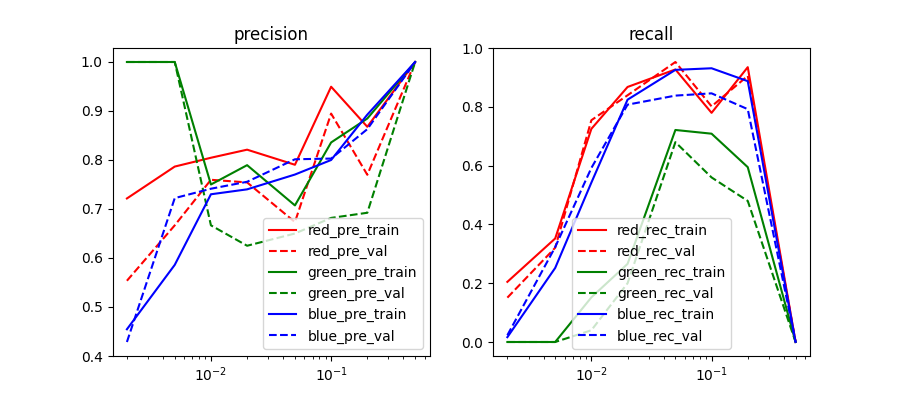

In [19]:
num_classes = len(np.unique(y))
xs = []

lst = [2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1]
ys = np.zeros((4, len(lst), num_classes))
filter_size1, filter_size2, filter_size3, kernel_size, pool_size, lr = 12, 16, 20, (5, 5), (2, 2), 1e-3
for ind, i in enumerate(lst):
    pre_train, rec_train, pre_val, rec_val = [], [], [], []
    for j in range(30):
        precision_train, recall_train, precision_val, recall_val = lenet5_same(filter_size1, filter_size2, filter_size3, kernel_size, pool_size, i)
        
        pre_train.append(precision_train)
        rec_train.append(recall_train)
        pre_val.append(precision_val)
        rec_val.append(recall_val)
        
    xs.append(i)
    ys[0][ind] = np.median(pre_train, axis=0)
    ys[1][ind] = np.median(rec_train, axis=0)
    ys[2][ind] = np.median(pre_val, axis=0)
    ys[3][ind] = np.median(rec_val, axis=0)
    
    print(ind, 'out of', len(lst))
    
# Represent The Data in Graphs
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(xs, ys[0,:,0], '-r', xs, ys[2,:,0], '--r',
          xs, ys[0,:,1], '-g', xs, ys[2,:,1], '--g',
          xs, ys[0,:,2], '-b', xs, ys[2,:,2], '--b')
ax[0].set_title('precision')
ax[0].set_xscale('log')
ax[0].legend(['red_pre_train', 'red_pre_val',
             'green_pre_train', 'green_pre_val',
             'blue_pre_train', 'blue_pre_val'], loc='best')

ax[1].plot(xs, ys[1,:,0], '-r', xs, ys[3,:,0], '--r',
          xs, ys[1,:,1], '-g', xs, ys[3,:,1], '--g',
          xs, ys[1,:,2], '-b', xs, ys[3,:,2], '--b')
ax[1].set_title('recall')
ax[1].set_xscale('log')
ax[1].legend(['red_rec_train', 'red_rec_val',
             'green_rec_train', 'green_rec_val',
             'blue_rec_train', 'blue_rec_val'], loc='best')

fig.savefig('lr_SGD2_img(12, 16, 20, (5, 5), (2, 2), 1e-3).png')
np.save('lr_SGD2_x(12, 16, 20, (5, 5), (2, 2), 1e-3).npy', xs)
np.save('lr_SGD2_y(12, 16, 20, (5, 5), (2, 2), 1e-3).npy', ys)